This is a workbook to play around with models and save one for use in my demo.

In [1]:
'''This is my setup block.'''
from sqlalchemy import create_engine #SQL
from sqlalchemy_utils import database_exists, create_database #SQL
import psycopg2 #SQL
import pandas as pd #SQL, python

import numpy as np #sklearn
import matplotlib.pyplot as plt #sklearn
from sklearn.model_selection import train_test_split #sklearn

from sklearn.tree import DecisionTreeRegressor #sklearn decision tree
from sklearn.ensemble import RandomForestRegressor #random forest regressor
from sklearn.ensemble import RandomForestClassifier #random forest classifier
from sklearn.multioutput import MultiOutputRegressor #random forest
from sklearn import svm #SVM
from sklearn.decomposition import PCA #PCA
from sklearn.metrics import confusion_matrix #for validation

import pickle #for saving off a trained model

import time #python
from datetime import date
start = time.mktime(time.localtime())

%matplotlib inline

dbname = 'steamspy'
username = 'alan'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

#seed = np.random.randint(0,high=10000)
seed = 6702 
print("random seed:",seed)

random seed: 6702


In [9]:
#sql_query = '''SELECT appid FROM indie_demo;'''
#appids = pd.read_sql_query(sql_query,engine)
##appids = [413150] #placeholder, replace with actual DF
#print("Retrieved appids from SQL")

This next section handles my database calls. I also want to remove "free" games from my dataset, since they (presumably) use a different revenue model for which I can't get data. The reporting numbers are just a sanity check to see how many titles I pull out. Right now, they're about 7500, which is enough to make me reasonably happy I can do something with the data.

In [2]:
#pull from DB:steamspy TABLE:indie_demo
#do some data preprocessing to create a usable pandas dataframe that I can feed into sklearn

'''pull all of my pre-processed indie data'''
sql_query = '''SELECT * FROM indie_demo;'''
indies = pd.read_sql_query(sql_query,engine)
#indies.fillna(value=0,inplace=True)

print("indies:",len(indies)) #debug: how many records did I pull?
#list(indies)

indies: 7573


In [3]:
#Get rid of the things that scale with owners/revenue and unique identifiers (appid, name) that mess things up
dropnames = ['index','appid','name','developer','publisher','release']
dropscale = ['postowners','newowners','saleprice','price','salerevenue']
to_output = indies['price']
to_input = indies.drop(dropnames,axis=1)
to_input.drop(dropscale,axis=1,inplace=True)

#I want my training input to be the 'to_input' dataframe
input_train, input_test, output_train, output_test = \
    train_test_split(to_input, to_output, test_size=0.2, random_state=seed)
    #training output should be revenue_category

#list(to_input) #debug
print("Done!")

Done!


Now I have a dataframe that I can put into a model, so go ahead and use sklearn to do that.

Here's some sample code for a decision tree with multiple outputs. http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression_multioutput.html

In [147]:
'''
#Fit a decision tree regression model
dec_tree = DecisionTreeRegressor(max_depth=14) #change the depth to adjust model
dec_tree.fit(input_train, output_train)

#Spot test my model
test = np.random.randint(0,high=len(input_test))
test_input = input_test.iloc[test].values.reshape(1,-1)
print(input_test.iloc[test])

prediction = dec_tree.predict(test_input)

print("Prediction:",prediction)
print("Actual value is:",output_test.iloc[test])
'''

'\n#Fit a decision tree regression model\ndec_tree = DecisionTreeRegressor(max_depth=14) #change the depth to adjust model\ndec_tree.fit(input_train, output_train)\n\n#Spot test my model\ntest = np.random.randint(0,high=len(input_test))\ntest_input = input_test.iloc[test].values.reshape(1,-1)\nprint(input_test.iloc[test])\n\nprediction = dec_tree.predict(test_input)\n\nprint("Prediction:",prediction)\nprint("Actual value is:",output_test.iloc[test])\n'

In [4]:
#Fit a random forest regression model
'''
class sklearn.ensemble.RandomForestRegressor
(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2, 
min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, 
oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)
'''

max_depth = None
max_trees = 40

regr_rf = RandomForestRegressor(n_estimators = max_trees, 
                                max_depth=max_depth, random_state=2, 
                                oob_score=True, warm_start=True)
regr_rf.fit(input_train, output_train)

#with open('saved_rf.pkl', 'wb') as fid:
#    pickle.dump(regr_rf, fid)
print("Done!")

Done!


In [5]:
print("OOB score is:",regr_rf.oob_score_)
print("feature_importances_:",regr_rf.feature_importances_)

OOB score is: 0.171378492869
feature_importances_: [ 0.05996026  0.136154    0.06064919  0.07205666  0.07947742  0.05980752
  0.11445901  0.05513587  0.07453865  0.01292142  0.01376393  0.00731846
  0.02674321  0.00365759  0.00225332  0.00900984  0.01186005  0.00212524
  0.00886414  0.02683979  0.00254942  0.00380814  0.00338283  0.00499291
  0.00705039  0.00196759  0.00586265  0.00976555  0.02179711  0.00099469
  0.00648334  0.00816821  0.01277065  0.00318281  0.00265599  0.00385879
  0.02707219  0.00612011  0.00217765  0.02221529  0.00241077  0.00311734]


In [42]:
#Fit a random forest classifier model
'''
start = time.mktime(time.localtime())
print("Training RF classifier...")

max_depth = None
#example: RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)[source]¶

clf_rf = RandomForestClassifier(n_estimators=20, max_depth=max_depth, random_state=2)
clf_rf.fit(input_train, output_train)

finish = time.mktime(time.localtime())
runtime = finish - start
print("Finished processing in",runtime,"seconds!")
'''

'\nstart = time.mktime(time.localtime())\nprint("Training RF classifier...")\n\nmax_depth = None\n#example: RandomForestClassifier(n_estimators=10, criterion=\'gini\', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=\'auto\', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)[source]¶\n\nclf_rf = RandomForestClassifier(n_estimators=20, max_depth=max_depth, random_state=2)\nclf_rf.fit(input_train, output_train)\n\nfinish = time.mktime(time.localtime())\nruntime = finish - start\nprint("Finished processing in",runtime,"seconds!")\n'

In [46]:
#Let's try an SVM
'''
c_values = [.1, 1.0, 10.0, 100]
gamma_values = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
svm_models = {}
def train_svms():
    for c in c_values:
        svm_models[c] = {}
        for gamma in gamma_values:
            clf_svm = svm.SVC(C=c, tol=1e-10, cache_size=600, kernel='rbf', gamma=gamma, class_weight='balanced')
            clf_svm.fit(input_train, output_train) #takes about 17 seconds
            svm_models[c][gamma] = clf_svm



start = time.mktime(time.localtime())
print("Training SVM classifier...")
train_svms() #do a thing

finish = time.mktime(time.localtime())
runtime = finish - start
print("Finished processing in",runtime,"seconds!")
'''

#clf = svm_models[1000][1e-10] #change these values to inspect individual models

'\nc_values = [.1, 1.0, 10.0, 100]\ngamma_values = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]\nsvm_models = {}\ndef train_svms():\n    for c in c_values:\n        svm_models[c] = {}\n        for gamma in gamma_values:\n            clf_svm = svm.SVC(C=c, tol=1e-10, cache_size=600, kernel=\'rbf\', gamma=gamma, class_weight=\'balanced\')\n            clf_svm.fit(input_train, output_train) #takes about 17 seconds\n            svm_models[c][gamma] = clf_svm\n\n\n\nstart = time.mktime(time.localtime())\nprint("Training SVM classifier...")\ntrain_svms() #do a thing\n\nfinish = time.mktime(time.localtime())\nruntime = finish - start\nprint("Finished processing in",runtime,"seconds!")\n'

In [67]:
#Let's try an SVM
#SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
#    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
    
c_values = [.1, 1.0, 10.0, 100, 1000]
gamma_values = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8]
svm_models = {}
def train_svms():
    for c in c_values:
        svm_models[c] = {}
        for g in gamma_values:
            clf_svm = svm.SVR(C=c, tol=1e-10, cache_size=600, kernel='rbf', gamma=g)
            clf_svm.fit(input_train, output_train) #takes about 17 seconds
            svm_models[c][g] = clf_svm

start = time.mktime(time.localtime())
print("Training SVM classifier...")
train_svms() #do a thing

finish = time.mktime(time.localtime())
runtime = finish - start
print("Finished processing in",runtime,"seconds!")


#clf = svm_models[1000][1e-10] #change these values to inspect individual models

Training SVM classifier...
Finished processing in 949.0 seconds!


In [71]:
from sklearn.neighbors import KNeighborsRegressor
start = time.mktime(time.localtime())
print("Training K-neighbor regressor...")
      
regr_kn = KNeighborsRegressor(n_neighbors=8)
regr_kn.fit(input_train, output_train) 

finish = time.mktime(time.localtime())
runtime = finish - start
print("Finished processing in",runtime,"seconds!")

Training K-neighbor regressor...
Finished processing in 0.0 seconds!


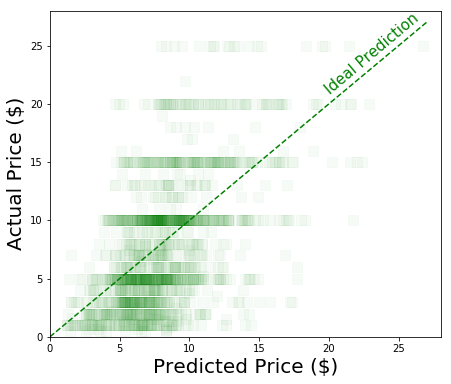

In [9]:
#run my entire test set
def test_model(model):
    results = {}
    for i in range(len(input_test)):
        test_input = input_test.iloc[i].values.reshape(1,-1)
        prediction = model.predict(test_input)
        results[i] = {}
        #print("Prediction:",prediction[0])
        results[i]['prediction'] = prediction[0]
        #print("Actual value is:",output_test.iloc[i])
        results[i]['actual'] = output_test.iloc[i]
    return(results)

results_df = pd.DataFrame.from_dict(test_model(regr_rf),orient='index')
#print(results_df)

x_cap = 28
y_cap = 28

plt.rcParams["figure.figsize"] = [7,6]

plt.scatter(results_df['prediction'],results_df['actual'],color='green',marker='s',alpha=0.03,s=100)
plt.plot(np.arange(0,x_cap), np.arange(0,y_cap), color='green', linestyle="--", alpha=1)

plt.xlim([0,x_cap])
plt.ylim([0,y_cap])
plt.xlabel('Predicted Price ($)', fontsize = '20')
plt.ylabel('Actual Price ($)', fontsize = '20')
plt.annotate("Ideal Prediction", (19.5,27), color="green", fontsize='15', rotation=40)

#plt.title('Actual vs. Predicted Price (USD)', fontsize = '24')

In [45]:
'''I probably want to save my trained model at some point so I don't have to keep rebuilding it at runtime.'''

#import cPickle
# save the classifier
with open('saved_model.pkl', 'wb') as fid:
    pickle.dump(regr_rf, fid)    

#Can load it again later with this code
#with open('saved_model.pkl', 'rb') as fid:
#    clf = pickle.load(fid)
print("Done!")

Done!


In [70]:
finish = time.mktime(time.localtime())
runtime = finish - start
print("Finished processing in",runtime,"seconds!")

Finished processing in 69.0 seconds!
